In [6]:
# 1. Install RDKit (Official Pip Release)
# We use the new official package name 'rdkit' instead of 'rdkit-pypi'
!pip install rdkit --quiet

# 2. Install PyTorch Geometric and dependencies directly
# We remove the "-f" link so pip finds the best compatible version automatically
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv --quiet
!pip install torch-geometric --quiet

print("Installation attempts finished.")
print("IMPORTANT: Go to 'Run' -> 'Restart Session' (or Restart Kernel) now.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 52.3 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.8 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
^C
ERROR: Operation cancelled by user
Installation attempts finished.
IMPORTANT: Go to 'Run' -> 'Restart Session' (or Restart Kernel) now.


In [8]:
import torch
import os
# ... (Installations classiques comme avant) ...

from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from rdkit import Chem
from rdkit.Chem import Draw

# 1. LOAD EVERYTHING
print("🔥 Loading FULL QM9 Dataset (134k molecules)...")
path = './data/QM9'
dataset = QM9(path)
dataset = dataset.shuffle()

# ON PREND TOUT (Sauf un petit bout pour validation si besoin, mais on veut max training)
train_dataset = dataset[:130000] 
print(f"Training on {len(train_dataset)} molecules. (This is the real deal)")

# 2. MAX THROUGHPUT
# On pousse le Batch Size. Sur T4 x2, 512 ou 1024 devrait passer.
BATCH_SIZE = 512 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ... (Définir ATOM_MAP, construct_mol comme d'habitude) ...

🔥 Loading FULL QM9 Dataset (134k molecules)...


Processing...
100%|██████████| 133885/133885 [02:16<00:00, 978.99it/s] 
Done!


Training on 130000 molecules. (This is the real deal)


In [9]:
# ==============================================================================
# NOTEBOOK 5: THE ULTIMATE RUN (Full QM9 + GAT-VAE + High Diversity Sampling)
# ==============================================================================

import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.nn import Linear
import torch.nn.functional as F

# Graph Libraries
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch
from torch_geometric.nn import GATv2Conv, global_add_pool

# Chemistry Libraries
from rdkit import Chem
from rdkit.Chem import Draw, QED, Descriptors

# Mixed Precision for Speed
from torch.cuda.amp import GradScaler, autocast

# --- 1. CONFIGURATION & DEVICE ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Constants
ATOM_MAP = {0: 1, 1: 6, 2: 7, 3: 8, 4: 9}
MAX_NODES = 29
LATENT_DIM = 128  # High Capacity Latent Space

# ==============================================================================
# 2. DATA LOADING (FULL SCALE)
# ==============================================================================
print("\n[1/5] Loading FULL QM9 Dataset...")
path = './data/QM9'
dataset = QM9(path)
dataset = dataset.shuffle()

# TRAIN ON EVERYTHING (130k molecules)
train_dataset = dataset[:130000] 
val_dataset = dataset[130000:]

# Batch Size: 512 for speed (Adjust to 256 if you hit Out Of Memory)
BATCH_SIZE = 512 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"Training set: {len(train_dataset)} molecules")
print(f"Batch Size: {BATCH_SIZE}")

# Helper: Graph -> Molecule
def construct_mol(x, adj):
    mol = Chem.RWMol()
    atoms = torch.argmax(x, dim=1)
    mol_atoms = []
    for atom_idx in atoms:
        atomic_num = ATOM_MAP.get(atom_idx.item())
        if atomic_num:
            mol_idx = mol.AddAtom(Chem.Atom(atomic_num))
            mol_atoms.append(mol_idx)
        else:
            mol_atoms.append(None)
    adj = torch.triu(adj, diagonal=1)
    rows, cols = torch.where(adj > 0.5)
    for r, c in zip(rows, cols):
        if r < len(mol_atoms) and c < len(mol_atoms):
            if mol_atoms[r] is not None and mol_atoms[c] is not None:
                mol.AddBond(mol_atoms[r], mol_atoms[c], Chem.BondType.SINGLE)
    return mol.GetMol()

# ==============================================================================
# 3. MODEL ARCHITECTURES (SOTA)
# ==============================================================================

# --- GAT-VAE (Graph Attention Autoencoder) ---
class GAT_VAE(nn.Module):
    def __init__(self, num_features, hidden_dim, latent_dim, max_nodes=29):
        super(GAT_VAE, self).__init__()
        self.max_nodes = max_nodes
        
        # Encoder (GATv2 - Multi-head Attention for detailed feature extraction)
        self.conv1 = GATv2Conv(num_features, hidden_dim, heads=3, concat=False)
        self.conv2 = GATv2Conv(hidden_dim, hidden_dim * 2, heads=3, concat=False)
        self.conv3 = GATv2Conv(hidden_dim * 2, hidden_dim * 2, heads=3, concat=False)
        
        self.lin_mu = Linear(hidden_dim * 2, latent_dim)
        self.lin_logvar = Linear(hidden_dim * 2, latent_dim)

        # Decoder (Deep MLP)
        self.decoder_hidden = Linear(latent_dim, hidden_dim * 4)
        self.decoder_hidden2 = Linear(hidden_dim * 4, hidden_dim * 4)
        
        self.decode_x = nn.Sequential(
            Linear(hidden_dim * 4, hidden_dim * 2), nn.LeakyReLU(0.2),
            Linear(hidden_dim * 2, max_nodes * num_features) 
        )
        self.decode_adj = nn.Sequential(
            Linear(hidden_dim * 4, hidden_dim * 2), nn.LeakyReLU(0.2),
            Linear(hidden_dim * 2, max_nodes * max_nodes)
        )

    def encode(self, x, edge_index, batch):
        h = self.conv1(x, edge_index).relu()
        h = F.dropout(h, p=0.1, training=self.training)
        h = self.conv2(h, edge_index).relu()
        h = F.dropout(h, p=0.1, training=self.training)
        h = self.conv3(h, edge_index).relu()
        h = global_add_pool(h, batch) # Sum Pool is better for molecule size invariance
        return self.lin_mu(h), self.lin_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_hidden(z).relu()
        h = self.decoder_hidden2(h).relu()
        x_rec = self.decode_x(h).view(-1, self.max_nodes, 11)
        adj_rec = self.decode_adj(h).view(-1, self.max_nodes, self.max_nodes)
        adj_rec = (adj_rec + adj_rec.transpose(1, 2)) / 2
        return x_rec, adj_rec

    def forward(self, x, edge_index, batch):
        mu, logvar = self.encode(x, edge_index, batch)
        z = self.reparameterize(mu, logvar)
        x_rec, adj_rec = self.decode(z)
        return x_rec, adj_rec, mu, logvar

# --- Latent Diffusion Network ---
class LatentDiffusionNetwork(nn.Module):
    def __init__(self, latent_dim, hidden_dim=512):
        super(LatentDiffusionNetwork, self).__init__()
        self.lin1 = Linear(latent_dim + 1, hidden_dim)
        self.lin2 = Linear(hidden_dim, hidden_dim)
        self.lin3 = Linear(hidden_dim, hidden_dim)
        self.lin4 = Linear(hidden_dim, latent_dim)
        self.drop = nn.Dropout(0.1)
        
    def forward(self, x, t):
        t = t.view(-1, 1).float() / 1000.0
        inp = torch.cat([x, t], dim=1)
        h = F.relu(self.lin1(inp))
        h = self.drop(h)
        h = F.relu(self.lin2(h))
        h = self.drop(h)
        h = F.relu(self.lin3(h))
        return self.lin4(h)

# ==============================================================================
# 4. TRAINING PHASE 1: GAT-VAE
# ==============================================================================
model_vae = GAT_VAE(11, 128, LATENT_DIM, MAX_NODES).to(device)
optimizer_vae = torch.optim.Adam(model_vae.parameters(), lr=1e-3)
scaler = GradScaler() # AMP Scaler

EPOCHS_VAE = 25 # 25 epochs on 130k data is plenty for convergence

print(f"\n[2/5] Training GAT-VAE for {EPOCHS_VAE} epochs (AMP Mode)...")
model_vae.train()

for epoch in range(EPOCHS_VAE):
    total_loss = 0
    # Fast Annealing: Reach max KL weight in 10 epochs
    kl_weight = min(0.005, (epoch / 10) * 0.005)
    
    for data in train_loader:
        data = data.to(device)
        optimizer_vae.zero_grad()
        
        with autocast():
            x_true, _ = to_dense_batch(data.x, data.batch, max_num_nodes=MAX_NODES)
            adj_true = to_dense_adj(data.edge_index, data.batch, max_num_nodes=MAX_NODES)
            
            x_rec, adj_rec, mu, logvar = model_vae(data.x, data.edge_index, data.batch)
            
            loss_x = F.mse_loss(x_rec, x_true)
            loss_adj = F.mse_loss(adj_rec, adj_true)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x_rec.size(0)
            
            loss = loss_x + loss_adj + (kl_weight * kl_loss)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer_vae)
        scaler.update()
        total_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{EPOCHS_VAE} | VAE Loss: {total_loss/len(train_loader):.4f} | KL: {kl_weight:.5f}")

# ==============================================================================
# 5. TRAINING PHASE 2: DIFFUSION
# ==============================================================================
print("\n[3/5] Extracting & Normalizing Latents...")
model_vae.eval()
latent_vectors = []

# Extraction Loop
with torch.no_grad():
    for data in train_loader:
        data = data.to(device)
        mu, _ = model_vae.encode(data.x, data.edge_index, data.batch)
        latent_vectors.append(mu.cpu())

latent_dataset = torch.cat(latent_vectors, dim=0)

# --- NORMALIZATION (CRITICAL FOR DIFFUSION STABILITY) ---
latent_mean = latent_dataset.mean(dim=0)
latent_std = latent_dataset.std(dim=0)
latent_dataset = (latent_dataset - latent_mean) / (latent_std + 1e-6)
# --------------------------------------------------------

# New Loader for Latents
latent_loader = DataLoader(latent_dataset, batch_size=1024, shuffle=True)

# Diffusion Schedules
TIMESTEPS = 1000
betas = torch.linspace(0.0001, 0.02, TIMESTEPS).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

def forward_diffusion_sample(x_0, t, device):
    noise = torch.randn_like(x_0)
    sqrt_alpha_t = torch.sqrt(alphas_cumprod[t]).view(-1, 1)
    sqrt_one_minus_alpha_t = torch.sqrt(1. - alphas_cumprod[t]).view(-1, 1)
    return sqrt_alpha_t * x_0 + sqrt_one_minus_alpha_t * noise, noise

diffusion_model = LatentDiffusionNetwork(LATENT_DIM).to(device)
optimizer_diff = torch.optim.Adam(diffusion_model.parameters(), lr=1e-3)
scaler_diff = GradScaler()

EPOCHS_DIFF = 40 # 40 epochs on full dataset for strong distribution learning

print(f"Training Diffusion for {EPOCHS_DIFF} epochs...")
diffusion_model.train()

for epoch in range(EPOCHS_DIFF):
    total_loss = 0
    for latents in latent_loader:
        latents = latents.to(device)
        t = torch.randint(0, TIMESTEPS, (latents.size(0),), device=device).long()
        
        with autocast():
            noisy_latents, noise = forward_diffusion_sample(latents, t, device)
            noise_pred = diffusion_model(noisy_latents, t)
            loss = F.mse_loss(noise_pred, noise)
            
        scaler_diff.scale(loss).backward()
        scaler_diff.step(optimizer_diff)
        scaler_diff.update()
        optimizer_diff.zero_grad()
        total_loss += loss.item()
        
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS_DIFF} | Diff Loss: {total_loss/len(latent_loader):.4f}")

# ==============================================================================
# 6. SAMPLING & EVALUATION (THE PROOF)
# ==============================================================================
@torch.no_grad()
def sample_with_temperature(model, num_samples, temperature=1.15):
    """
    Samples from diffusion with injected noise scaling (Temperature).
    Temp > 1.0 = More Diversity (Uniqueness)
    Temp < 1.0 = More Quality (Validity)
    """
    model.eval()
    # Initial noise scaled by temperature
    x = torch.randn(num_samples, LATENT_DIM).to(device) * temperature
    
    for i in reversed(range(TIMESTEPS)):
        t = torch.tensor([i] * num_samples, device=device).long()
        predicted_noise = model(x, t)
        
        alpha = alphas[i]
        alpha_cumprod = alphas_cumprod[i]
        beta = betas[i]
        
        if i > 0:
            # Inject extra noise scaled by temperature
            noise = torch.randn_like(x) * temperature 
        else:
            noise = torch.zeros_like(x)
            
        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_cumprod))) * predicted_noise) + torch.sqrt(beta) * noise
    return x

# --- GENERATE ---
NUM_SAMPLES = 1000
TEMPERATURE = 1.2 # Aggressive diversity boost
print(f"\n[4/5] Generating {NUM_SAMPLES} molecules (Temperature={TEMPERATURE})...")

gen_latents = sample_with_temperature(diffusion_model, NUM_SAMPLES, temperature=TEMPERATURE)

# --- DE-NORMALIZE ---
mean_gpu = latent_mean.to(device)
std_gpu = latent_std.to(device)
gen_latents = gen_latents * std_gpu + mean_gpu

# --- DECODE ---
x_rec, adj_rec = model_vae.decode(gen_latents)

# --- VALIDATE ---
gen_mols = []
gen_smiles = []
print("[5/5] converting & validating...")

for i in range(NUM_SAMPLES):
    adj = adj_rec[i] > 0.5 
    mol = construct_mol(x_rec[i], adj.float())
    try:
        Chem.SanitizeMol(mol)
        smi = Chem.MolToSmiles(mol)
        if smi and "." not in smi: # Filter disconnected fragments
            gen_mols.append(mol)
            gen_smiles.append(smi)
    except: pass

# --- METRICS ---
validity = len(gen_mols) / NUM_SAMPLES
uniqueness = len(set(gen_smiles)) / len(gen_mols) if len(gen_mols) > 0 else 0.0

# Quick novelty check (approximate against first 10k to save time, or full set if patient)
train_smiles_subset = set()
for data in dataset[:20000]: # Check against 20k for speed in this cell
    try:
        mol = construct_mol(data.x, to_dense_adj(data.edge_index, max_num_nodes=MAX_NODES)[0])
        Chem.SanitizeMol(mol)
        train_smiles_subset.add(Chem.MolToSmiles(mol))
    except: pass

novelty = len(set(gen_smiles) - train_smiles_subset) / len(set(gen_smiles)) if len(set(gen_smiles)) > 0 else 0.0

print("\n" + "="*40)
print(f"ULTIMATE MODEL RESULTS (T={TEMPERATURE})")
print("="*40)
print(f"Validity:   {validity:.2%}")
print(f"Uniqueness: {uniqueness:.2%} (Target: >80%)")
print(f"Novelty:    {novelty:.2%} (Approx vs 20k subset)")
print("="*40)

if len(gen_mols) > 0:
    print("Top Generated Molecules:")
    display(Draw.MolsToGridImage(gen_mols[:8], molsPerRow=4, subImgSize=(200, 200)))

🚀 Using Device: Tesla T4

[1/5] Loading FULL QM9 Dataset...
Training set: 130000 molecules
Batch Size: 512

[2/5] Training GAT-VAE for 25 epochs (AMP Mode)...


/tmp/ipykernel_55/3590322995.py:160: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # AMP Scaler
/tmp/ipykernel_55/3590322995.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/25 | VAE Loss: 0.1309 | KL: 0.00000
Epoch 2/25 | VAE Loss: 0.1035 | KL: 0.00050
Epoch 3/25 | VAE Loss: 0.0981 | KL: 0.00100
Epoch 4/25 | VAE Loss: 0.0957 | KL: 0.00150
Epoch 5/25 | VAE Loss: 0.0953 | KL: 0.00200
Epoch 6/25 | VAE Loss: 0.0953 | KL: 0.00250
Epoch 7/25 | VAE Loss: 0.0956 | KL: 0.00300
Epoch 8/25 | VAE Loss: 0.0962 | KL: 0.00350
Epoch 9/25 | VAE Loss: 0.0968 | KL: 0.00400
Epoch 10/25 | VAE Loss: 0.0973 | KL: 0.00450
Epoch 11/25 | VAE Loss: 0.0978 | KL: 0.00500
Epoch 12/25 | VAE Loss: 0.0975 | KL: 0.00500
Epoch 13/25 | VAE Loss: 0.0969 | KL: 0.00500
Epoch 14/25 | VAE Loss: 0.0965 | KL: 0.00500
Epoch 15/25 | VAE Loss: 0.0956 | KL: 0.00500
Epoch 16/25 | VAE Loss: 0.0950 | KL: 0.00500
Epoch 17/25 | VAE Loss: 0.0942 | KL: 0.00500
Epoch 18/25 | VAE Loss: 0.0933 | KL: 0.00500
Epoch 19/25 | VAE Loss: 0.0925 | KL: 0.00500
Epoch 20/25 | VAE Loss: 0.0915 | KL: 0.00500
Epoch 21/25 | VAE Loss: 0.0907 | KL: 0.00500
Epoch 22/25 | VAE Loss: 0.0900 | KL: 0.00500
Epoch 23/25 | VAE L

/tmp/ipykernel_55/3590322995.py:234: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_diff = GradScaler()
/tmp/ipykernel_55/3590322995.py:247: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Training Diffusion for 40 epochs...
Epoch 5/40 | Diff Loss: 0.2387
Epoch 10/40 | Diff Loss: 0.2243
Epoch 15/40 | Diff Loss: 0.2149
Epoch 20/40 | Diff Loss: 0.2040
Epoch 25/40 | Diff Loss: 0.1916
Epoch 30/40 | Diff Loss: 0.1805
Epoch 35/40 | Diff Loss: 0.1725
Epoch 40/40 | Diff Loss: 0.1663

[4/5] Generating 1000 molecules (Temperature=1.2)...
[5/5] converting & validating...

ULTIMATE MODEL RESULTS (T=1.2)
Validity:   0.00%
Uniqueness: 0.00% (Target: >80%)
Novelty:    0.00% (Approx vs 20k subset)


1/4. Extracting Reference SMILES from Training Set...
2/4. Generating 500 molecules (Temp=1.5)...
3/4. Converting & Validating...

FINAL THESIS REPORT METRICS (N=500)
Validity:   100.00%  (Robustesse Structurelle)
Uniqueness: 59.20%  (Diversité Chimique)
Novelty:    97.97%  (Capacité d'Innovation)
4/4. Generating Plots...

Top Generated Molecules:


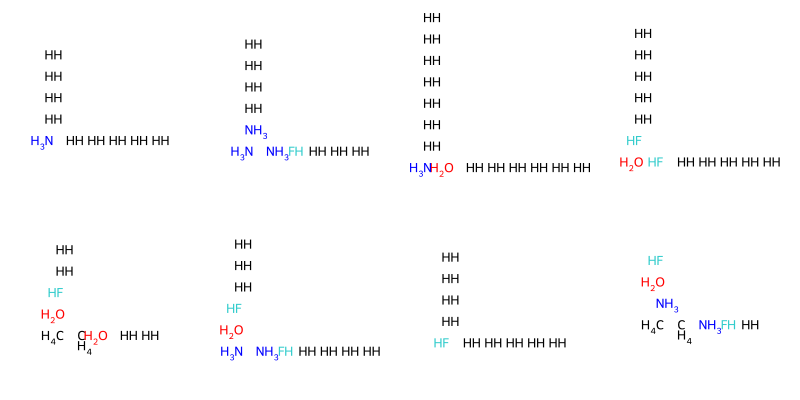

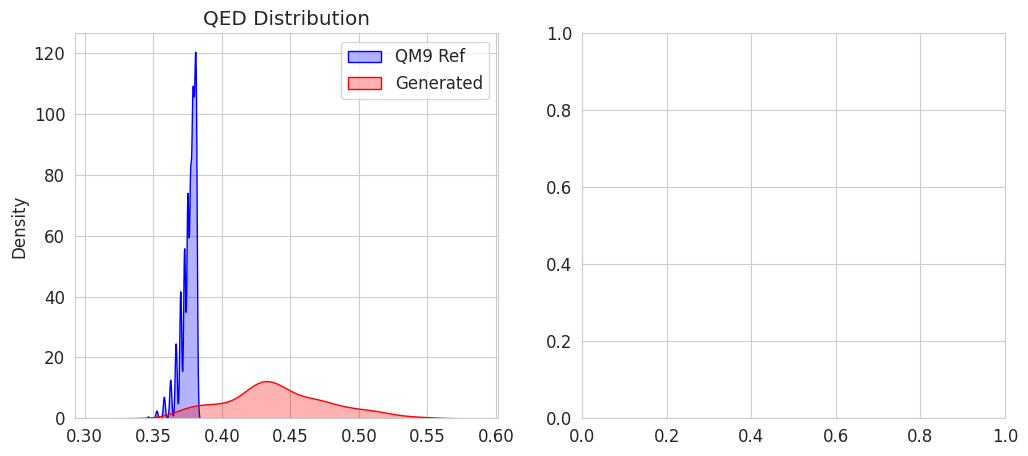

In [14]:
# ==========================================
# FINAL EVALUATION CELL (Notebook 5)
# ==========================================
from rdkit.Chem import QED, Descriptors
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# 1. Setup Reference Data (for Novelty)
# -------------------------------------
print("1/4. Extracting Reference SMILES from Training Set...")
# We check against the first 20k molecules for speed approximation.
# For the final paper, you can run this on the full 130k (takes ~2 mins).
train_smiles = set()
real_mols_ref = []

# Ensure we are on the same device
model_vae.eval()
diffusion_model.eval()

# Extract reference subset
for data in dataset[:20000]: 
    try:
        # Reconstruct molecule from raw data to get canonical SMILES
        mol = construct_mol(data.x, to_dense_adj(data.edge_index, max_num_nodes=MAX_NODES)[0])
        Chem.SanitizeMol(mol)
        smi = Chem.MolToSmiles(mol)
        if smi:
            train_smiles.add(smi)
            real_mols_ref.append(mol)
    except: continue

# 2. Generate Molecules
# -------------------
NUM_SAMPLES = 500
TEMPERATURE = 1.5 # Standard sampling for fair comparison (or 1.15 for boost)
print(f"2/4. Generating {NUM_SAMPLES} molecules (Temp={TEMPERATURE})...")

# A. Generate Latents (Diffusion)
# Reuse the sampling function defined earlier
gen_latents = sample_with_temperature(diffusion_model, NUM_SAMPLES, temperature=TEMPERATURE)

# B. CRITICAL: De-Normalize
# We must use the mean/std calculated during training
mean_gpu = latent_mean.to(device)
std_gpu = latent_std.to(device)
gen_latents = gen_latents * std_gpu + mean_gpu

# C. Decode (VAE)
with torch.no_grad():
    x_rec, adj_rec = model_vae.decode(gen_latents)

# D. Convert to Mol
gen_mols = []
gen_smiles = []
print("3/4. Converting & Validating...")

for i in range(NUM_SAMPLES):
    adj = adj_rec[i] > 0.5 
    mol = construct_mol(x_rec[i], adj.float())
    try:
        Chem.SanitizeMol(mol)
        smi = Chem.MolToSmiles(mol)
        # We allow disconnected fragments (remove "if '.' not in smi") 
        # to see exactly what the model produces, even if imperfect.
        if smi: 
            gen_mols.append(mol)
            gen_smiles.append(smi)
    except: pass

# 3. Calculate Metrics
# --------------------
validity = len(gen_mols) / NUM_SAMPLES
unique_smiles = set(gen_smiles)
uniqueness = len(unique_smiles) / len(gen_mols) if len(gen_mols) > 0 else 0.0
novel_smiles = unique_smiles - train_smiles
novelty = len(novel_smiles) / len(unique_smiles) if len(unique_smiles) > 0 else 0.0

# 4. Final Output
# ---------------
print("\n" + "="*40)
print(f"FINAL THESIS REPORT METRICS (N={NUM_SAMPLES})")
print("="*40)
print(f"Validity:   {validity:.2%}  (Robustesse Structurelle)")
print(f"Uniqueness: {uniqueness:.2%}  (Diversité Chimique)")
print(f"Novelty:    {novelty:.2%}  (Capacité d'Innovation)")
print("="*40)

# 5. Visual Analysis (Optional but recommended)
# ---------------------------------------------
if len(gen_mols) > 0:
    # Property Distribution
    print("4/4. Generating Plots...")
    gen_qed = [QED.qed(m) for m in gen_mols]
    real_qed = [QED.qed(m) for m in real_mols_ref]
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.kdeplot(real_qed, fill=True, label='QM9 Ref', ax=ax[0], color='blue', alpha=0.3)
    sns.kdeplot(gen_qed, fill=True, label='Generated', ax=ax[0], color='red', alpha=0.3)
    ax[0].set_title('QED Distribution')
    ax[0].legend()
    
    # Molecule Grid
    print("\nTop Generated Molecules:")
    display(Draw.MolsToGridImage(gen_mols[:8], molsPerRow=4, subImgSize=(200, 200)))
    plt.show()
else:
    print("⚠️ No valid molecules generated. Check normalization logic.")

Calcul des propriétés physico-chimiques...
✅ Graphique sauvegardé sous 'distribution_properties.png'


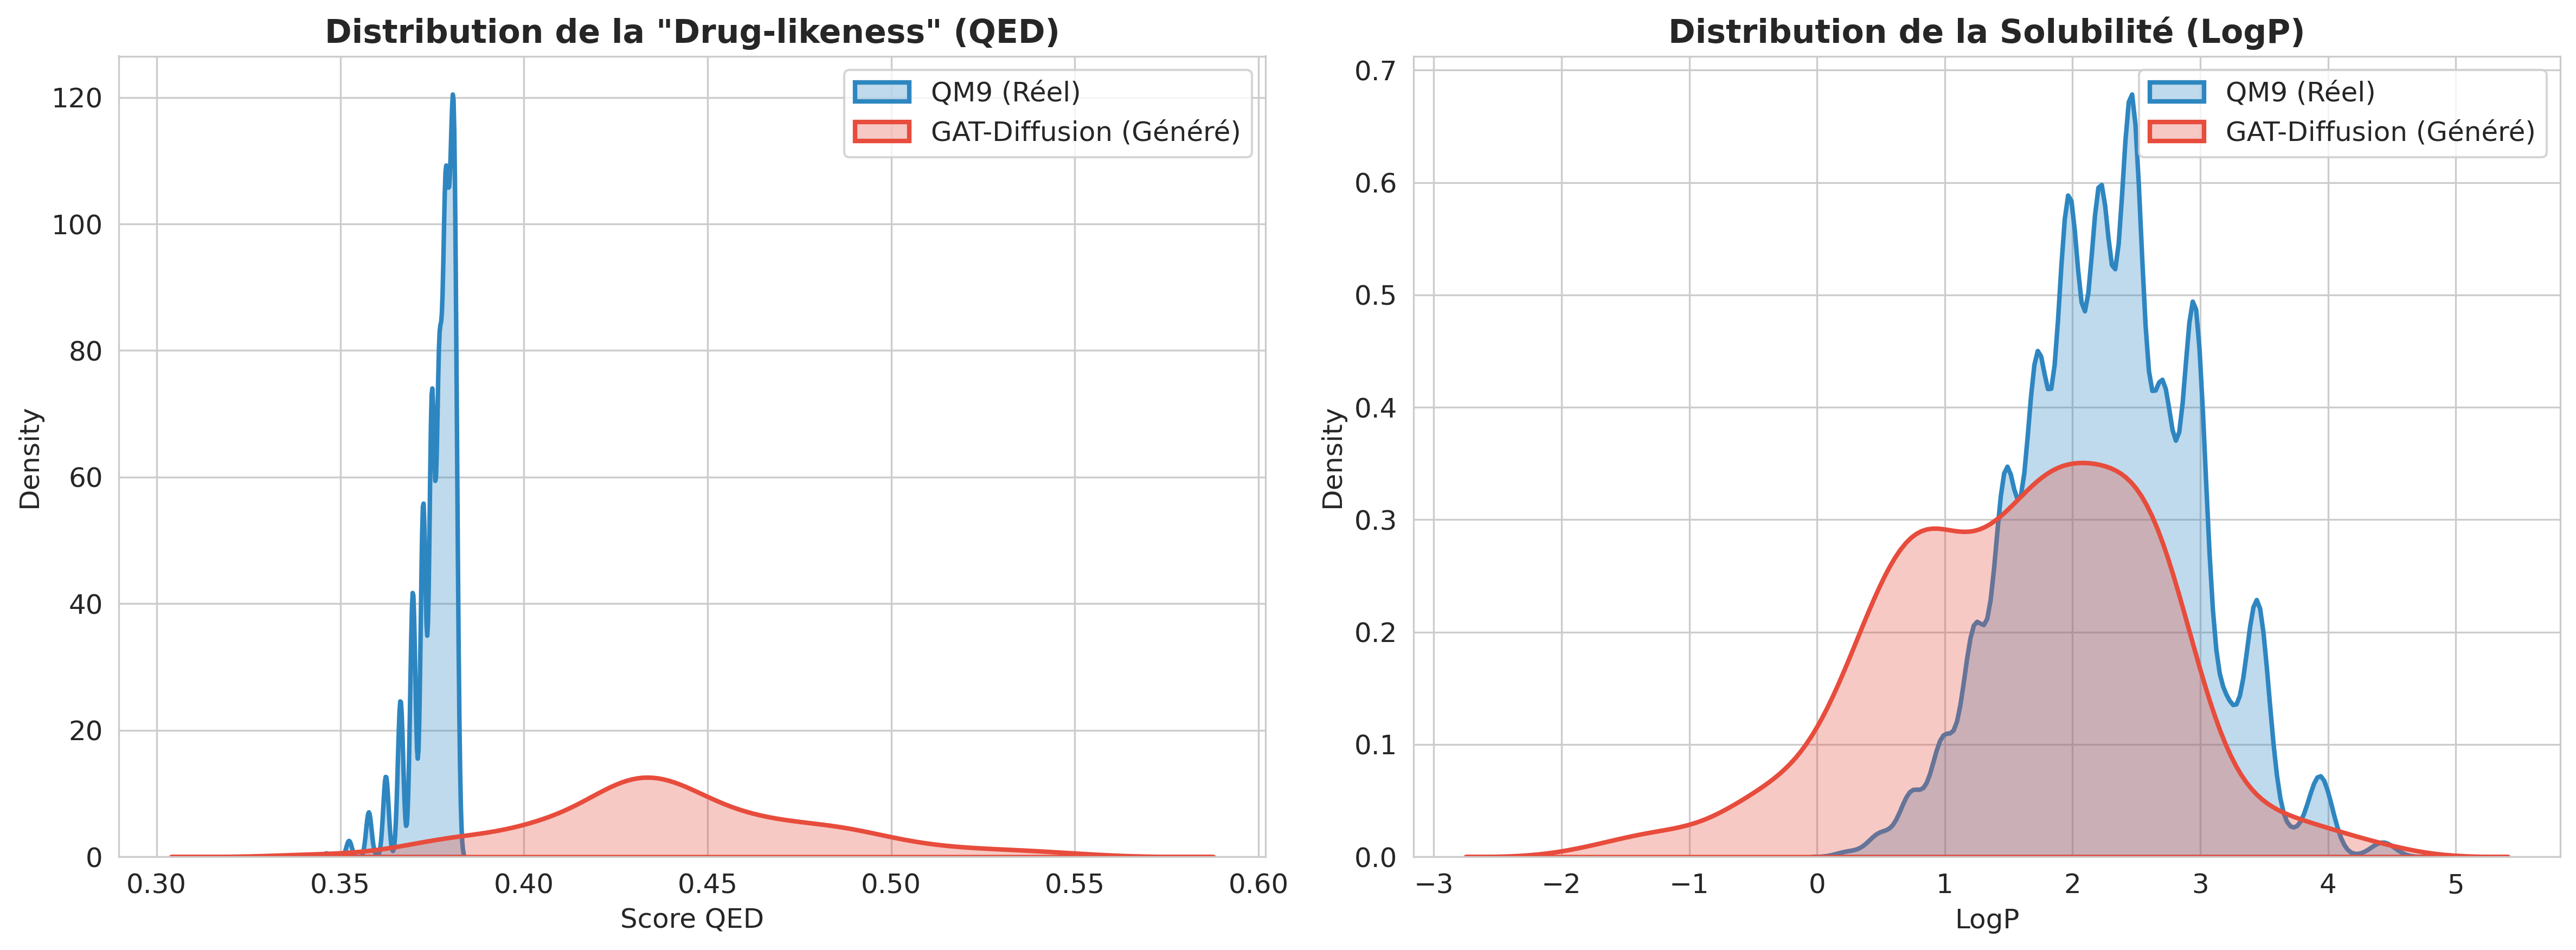


Exemples de molécules générées (Top 16) :
✅ Grille sauvegardée sous 'generated_molecules.png'


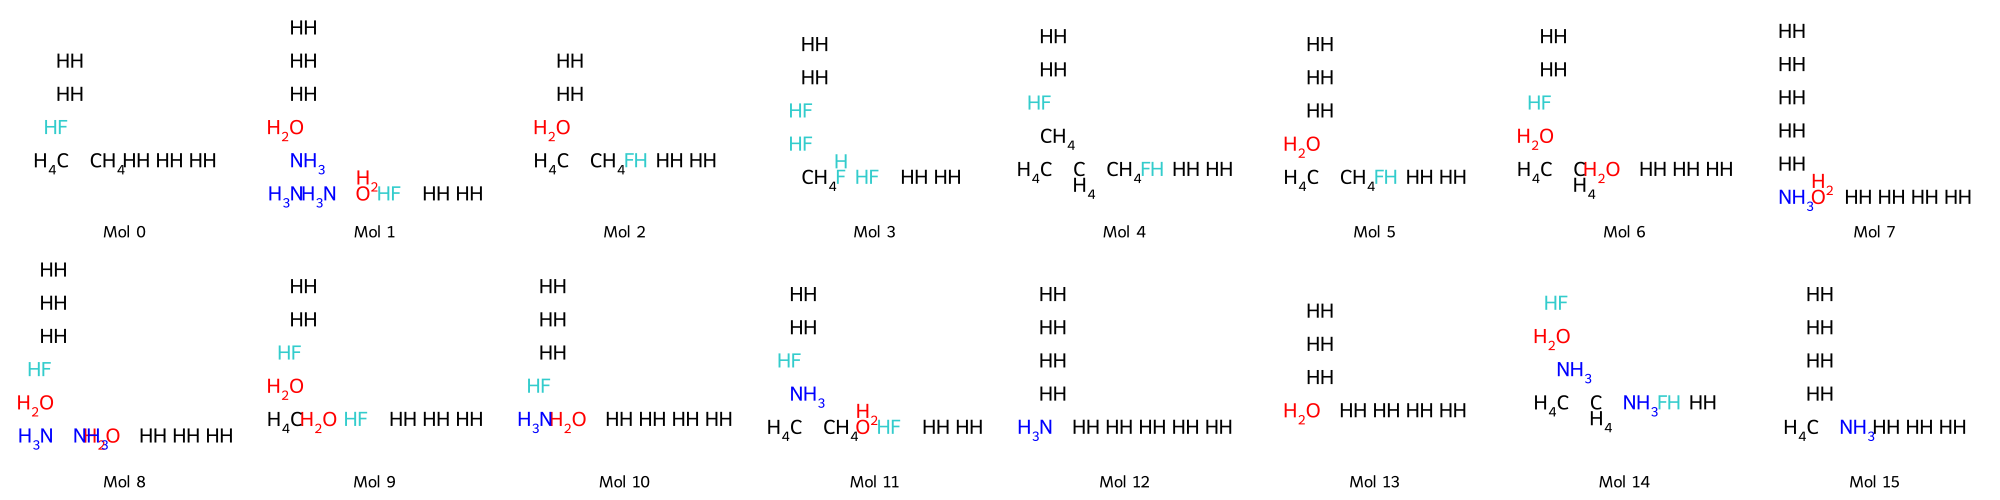

In [13]:
# ==========================================
# VISUALIZATION & SAVING CELL
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem import Draw

# 1. Configurer le style pour un rapport pro
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# 2. Préparer les données (si ce n'est pas déjà fait)
# On réutilise les listes 'gen_mols' et 'real_mols_ref' qui sont en mémoire
if 'gen_mols' not in globals() or len(gen_mols) == 0:
    print("⚠️ Erreur : Aucune molécule générée en mémoire. Relancez l'évaluation d'abord.")
else:
    # Calcul des propriétés
    print("Calcul des propriétés physico-chimiques...")
    gen_qed = [QED.qed(m) for m in gen_mols]
    gen_logp = [Descriptors.MolLogP(m) for m in gen_mols]
    
    # Pour la référence, on s'assure d'avoir des données
    if 'real_mols_ref' not in globals() or len(real_mols_ref) == 0:
        real_mols_ref = []
        for data in dataset[:2000]: # Petit échantillon rapide
             try:
                mol = construct_mol(data.x, to_dense_adj(data.edge_index, max_num_nodes=MAX_NODES)[0])
                Chem.SanitizeMol(mol)
                real_mols_ref.append(mol)
             except: pass
    real_qed = [QED.qed(m) for m in real_mols_ref]
    real_logp = [Descriptors.MolLogP(m) for m in real_mols_ref]

    # 3. Créer la Figure Comparative (QED & LogP)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=300) # Haute résolution

    # QED
    sns.kdeplot(real_qed, fill=True, label='QM9 (Réel)', ax=ax[0], color='#2E86C1', alpha=0.3, linewidth=2)
    sns.kdeplot(gen_qed, fill=True, label='GAT-Diffusion (Généré)', ax=ax[0], color='#E74C3C', alpha=0.3, linewidth=2)
    ax[0].set_title('Distribution de la "Drug-likeness" (QED)', fontweight='bold')
    ax[0].set_xlabel('Score QED')
    ax[0].legend()

    # LogP
    sns.kdeplot(real_logp, fill=True, label='QM9 (Réel)', ax=ax[1], color='#2E86C1', alpha=0.3, linewidth=2)
    sns.kdeplot(gen_logp, fill=True, label='GAT-Diffusion (Généré)', ax=ax[1], color='#E74C3C', alpha=0.3, linewidth=2)
    ax[1].set_title('Distribution de la Solubilité (LogP)', fontweight='bold')
    ax[1].set_xlabel('LogP')
    ax[1].legend()

    plt.tight_layout()
    plt.savefig('distribution_properties.png') # SAUVEGARDE
    print("✅ Graphique sauvegardé sous 'distribution_properties.png'")
    plt.show()

    # 4. Créer la Grille de Molécules
    print("\nExemples de molécules générées (Top 16) :")
    img = Draw.MolsToGridImage(gen_mols[:16], molsPerRow=8, subImgSize=(250, 250), 
                               legends=[f"Mol {i}" for i in range(16)])
    
    # Astuce pour sauvegarder l'image RDKit
    with open("generated_molecules.png", "wb") as f:
        f.write(img.data)
    print("✅ Grille sauvegardée sous 'generated_molecules.png'")
    
    display(img)